# Foreground Extraction Project
- Youssef George Fouad
- 19p9824
- CESS Senior 2

In [17]:
import os
import sys

# Get the path to the Python executable
python_executable_path = sys.executable

# Get the installation directory
python_installation_dir = os.path.dirname(python_executable_path)

print(f"Python executable path: {python_executable_path}")
print(f"Python installation directory: {python_installation_dir}")


Python executable path: /Users/youssefgeorge/.pyenv/versions/3.9.18/bin/python
Python installation directory: /Users/youssefgeorge/.pyenv/versions/3.9.18/bin


In [18]:
from model import GMM
import os
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np

In [50]:
dataset_base_path = 'dataset2012/dataset/'
dataset_type = 'dynamicBackground'
dataset_name = 'canoe'
dataset_path = dataset_base_path + dataset_type + '/' + dataset_name + '/input/'
groundtruth_path = dataset_base_path + dataset_type + '/' + dataset_name + '/groundtruth/'

- Helper function for color overlay

In [51]:
def color_overlay(image, mask):
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask[:,:,0] = 0
    mask[:,:,2] = 0
    mask = cv2.addWeighted(image, 1, mask, 0.5, 0)
    return mask

# Show Sample of video frames and ground truth

Number of images in the dataset:  1189 1189
Number of samples to view:  9 9


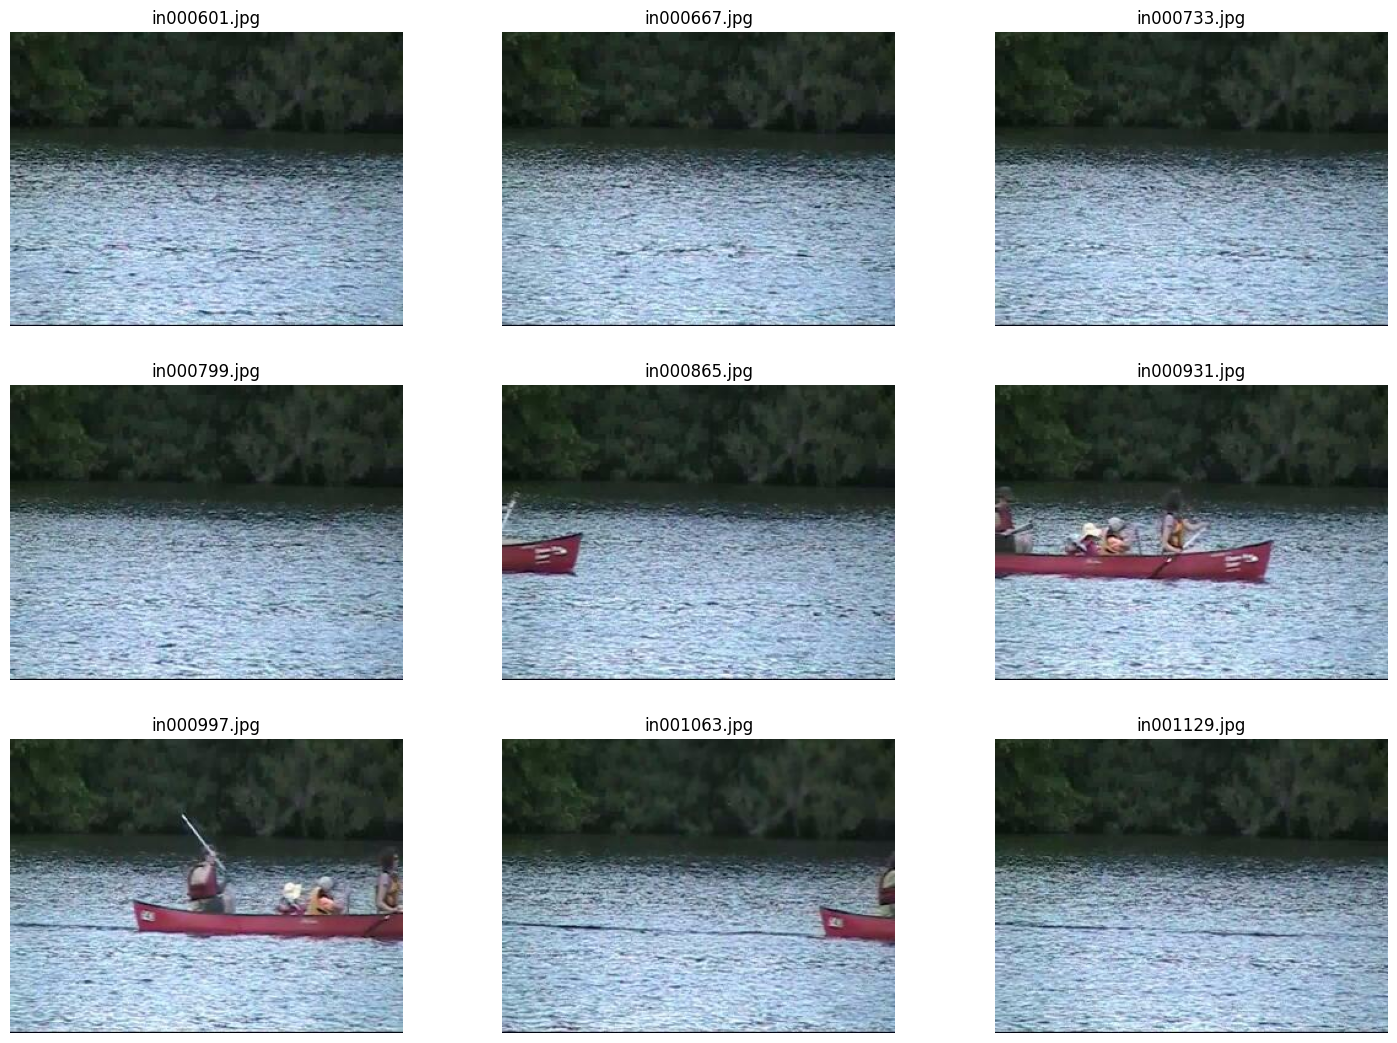

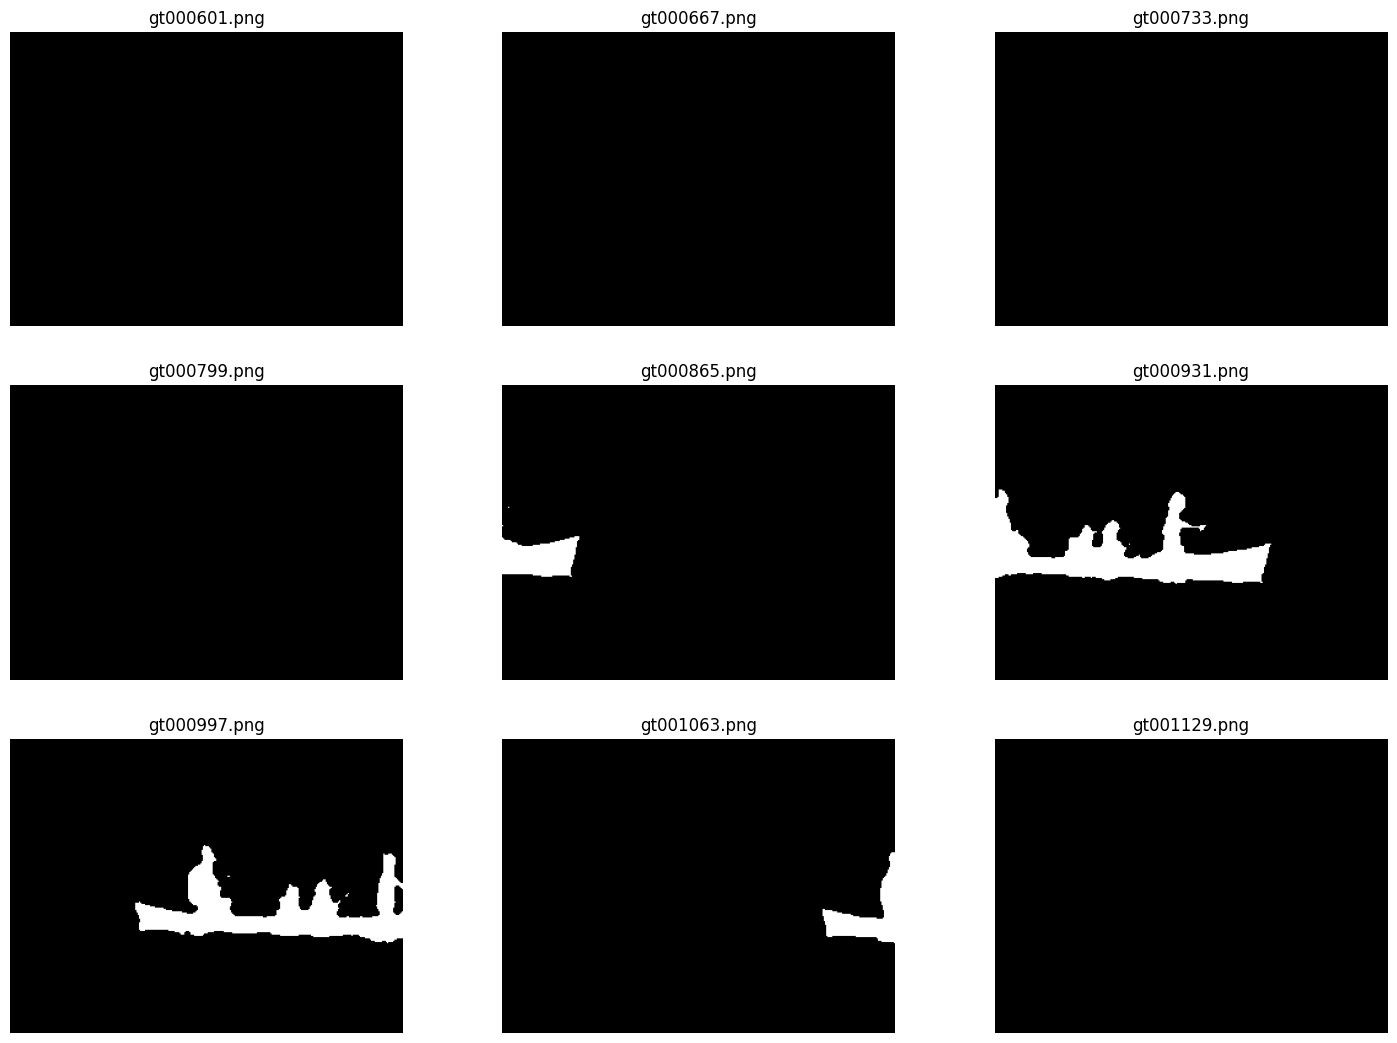

Original image size:  (240, 320)
Resized image size:  (200, 300)


In [60]:
# get the list of all the images in the dataset
images_names = [f for f in os.listdir(dataset_path) if f.endswith('.png') or f.endswith('.jpg')]
images_names.sort()
masks_names = [f for f in os.listdir(groundtruth_path) if f.endswith('.png') or f.endswith('.jpg')]
masks_names.sort()

samples = images_names[600::66]
gt_samples = masks_names[600::66]

print('Number of images in the dataset: ', len(images_names), len(masks_names))
print('Number of samples to view: ', len(samples), len(gt_samples))

fig, ax = plt.subplots(3, 3, figsize=(18, 13))
for i in range(3):
    for j in range(3):
        img = cv2.imread(dataset_path+samples[i*3+j])
        ax[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i, j].set_title(samples[i*3+j].split('/')[-1])
        ax[i, j].axis('off')
        ax[i, j].grid(False)
plt.show()

image_height, image_width, color_channels = img.shape

fig, ax = plt.subplots(3, 3, figsize=(18, 13))
for i in range(3):
    for j in range(3):
        img = cv2.imread(groundtruth_path+gt_samples[i*3+j], cv2.IMREAD_GRAYSCALE)
        img = np.where(img==255, 1, 0).astype(np.uint8)
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_title(gt_samples[i*3+j].split('/')[-1])
        ax[i, j].axis('off')
        ax[i, j].grid(False)
plt.show()        

print('Original image size: ', (image_height, image_width))

image_height, image_width = 200, 300 # resize the images to reduce the computation time
print('Resized image size: ', (image_height, image_width))

# Method 1: Adaptive GMM

- Updates GMM Gaussian distributions every frame

In [22]:
gmm = GMM(K_numOfGauss= 5, BG_thresh=0.3, alpha=0.01, height=image_height, width=image_width, colorChannels=color_channels)

In [23]:
output_dir = 'runs/gmm/'+dataset_type + '/' + dataset_name + '/' + time.strftime("%Y%m%d-%H%M%S") + '/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [24]:
frame_count = 0
update_frequency = 50
for frame_path in images_names:
    frame = cv2.imread(dataset_path+frame_path)
    frame = cv2.resize(frame, (image_width, image_height))
    if frame_count%update_frequency==0:
        print("number of frames: ", frame_count)
    
    BG_pivots = gmm.reorder()
    labels = gmm.updateParam(frame, BG_pivots)
    cv2.imwrite(output_dir+frame_path, labels)
    
    frame_count += 1

number of frames:  0
number of frames:  50
number of frames:  100
number of frames:  150
number of frames:  200
number of frames:  250
number of frames:  300


KeyboardInterrupt: 

## Evaluation + Visual Results

In [80]:
generated_dir = 'runs/gmm/'+dataset_type + '/' + dataset_name + '/20240602-221034/'
output_masks = os.listdir(generated_dir)
output_masks = [mask for mask in output_masks if mask.endswith('.jpg') or mask.endswith('.png')]
print('Number of generated masks: ', len(output_masks))
output_masks.sort()
accuracies = []
MAEs = []
IOUs = []
absolute_errors = []
for mask_name in output_masks:
    mask = cv2.imread(generated_dir+mask_name, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask>127, 1, 0).astype(np.uint8)
    gt = cv2.imread(groundtruth_path+mask_name.replace('in','gt').replace('jpg','png'), cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (image_width, image_height))
    gt = np.where(gt>127, 1, 0).astype(np.uint8)
    
    # Mean Absolute Error (MAE)
    mask = mask.flatten()
    gt = gt.flatten()
    difference = np.abs(mask-gt)
    difference = np.where(difference>127, 1, 0).astype(np.uint8)
    # mae = np.mean(np.abs(mask-gt))
    mae = np.mean(difference)
    MAEs.append(mae)

    # Intersection over Union (IoU)
    if np.sum(mask | gt) == 0:
        iou = 1
    else:
        iou = np.sum(mask & gt) / np.sum(mask | gt) 
    IOUs.append(iou)
    
    # Accuracy
    accuracy = np.sum(mask==gt) / mask.size 
    accuracies.append(accuracy)

np.save(generated_dir+'accuracies.npy', accuracies)
np.save(generated_dir+'MAEs.npy', MAEs)
np.save(generated_dir+'absolute_errors.npy', absolute_errors)
np.save(generated_dir+'IOUs.npy', IOUs)

with open(generated_dir+'results.txt', 'w') as f:
    f.write(f'{len(output_masks)} images Average Accuracy: '+str(np.mean(accuracies))+'\n')
    f.write('Accuracy:\n'+str(accuracies)+'\n')
    f.write(f'{len(output_masks)} images Average Mean Absolute Error: '+str(np.mean(MAEs))+'\n')
    f.write('Mean Absolute Error:\n'+str(MAEs)+'\n')
    f.write(f'{len(output_masks)} images Average Intersection over Union: '+str(np.mean(IOUs))+'\n')
    f.write('Intersection over Union:\n'+str(IOUs)+'\n')

Number of generated masks:  783


Average Accuracy: 93.0%
Average Mean Absolute Error: 7.000000000000001%
Average Intersection over Union: 5.0%


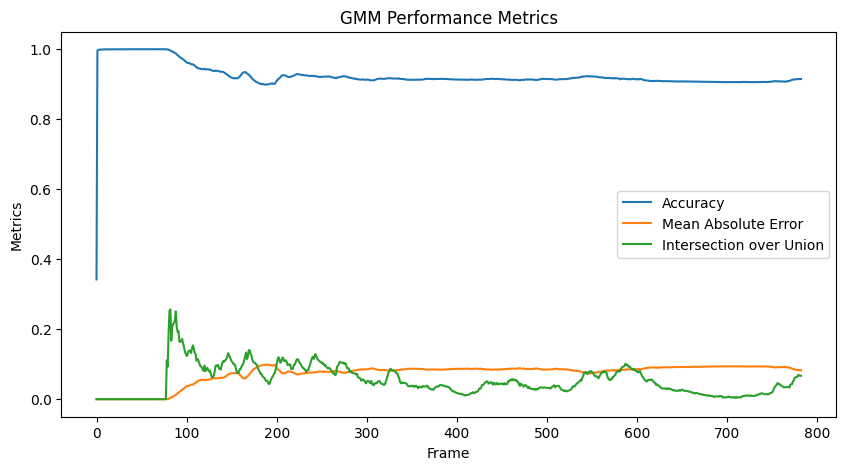

In [83]:
print(f'Average Accuracy: {np.mean(accuracies).round(2)*100}%')
print(f'Average Mean Absolute Error: {np.mean(MAEs).round(2)*100}%')
print(f'Average Intersection over Union: {np.mean(IOUs).round(2)*100}%')

plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.plot(MAEs, label='Mean Absolute Error')
plt.plot(IOUs, label='Intersection over Union')
plt.xlabel('Frame')
plt.ylabel('Metrics')
plt.legend()
plt.title('GMM Performance Metrics')
plt.show()

# Visualize generated masks in a video sequence

In [52]:
# load images
labels_dir = 'runs/gmm/'+dataset_type + '/' + dataset_name + '/20240602-221034/'
labels_names = [f for f in os.listdir(labels_dir) if f.endswith('.png') or f.endswith('.jpg')]
labels_names.sort()

video_output = labels_dir + 'output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 10
cap = cv2.VideoWriter(video_output, fourcc, fps, (image_width*3, image_height))

for img in labels_names:
    frame = cv2.imread(dataset_path+img)
    frame = cv2.resize(frame, (image_width, image_height))
    labels = cv2.imread(labels_dir+img, cv2.IMREAD_GRAYSCALE)
    highlighted_image = color_overlay(frame, labels)
    labels = cv2.cvtColor(labels, cv2.COLOR_GRAY2BGR)
    concated_image = np.concatenate((frame, labels, highlighted_image), axis=1)
    cap.write(concated_image)
cap.release()

# Method 2: Averaging frames

- Calculate background by averaging all previous frames
- Subtract new image from background and use threshold to determine foreground
- Update background by considering the new frame in the average calculations

In [45]:
output_dir = 'runs/classic/'+dataset_type + '/' + dataset_name + '/' + time.strftime("%Y%m%d-%H%M%S") + '/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [46]:
background = cv2.imread(dataset_path+images_names[0])
new_frame_weight = 0.001 # counts the last 1000 frames

for i, image in enumerate(images_names[1:]):
    frame = cv2.imread(dataset_path+image)
    background = cv2.addWeighted(background, 1-new_frame_weight, frame, new_frame_weight, 0)
    mask = cv2.absdiff(frame, background) # subtract the background from the frame to get the moving objects in the frame 
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(output_dir+image, mask)
    

## Visual Results

In [47]:
# load images
labels_dir = 'runs/classic/'+dataset_type + '/' + dataset_name + '/20240603-010533/'
labels_names = [f for f in os.listdir(labels_dir) if f.endswith('.png') or f.endswith('.jpg')]
labels_names.sort()

video_output = labels_dir + 'output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 10
sample_frame = cv2.imread(dataset_path+images_names[0])
print("width: ", sample_frame.shape[1], "height: ", sample_frame.shape[0])
cap = cv2.VideoWriter(video_output, fourcc, fps, (sample_frame.shape[1]*3, sample_frame.shape[0]))

for img in labels_names:
    frame = cv2.imread(dataset_path+img)
    labels = cv2.imread(labels_dir+img, cv2.IMREAD_GRAYSCALE)
    highlighted_image = color_overlay(frame, labels)
    labels = cv2.cvtColor(labels, cv2.COLOR_GRAY2BGR)
    concated_image = np.concatenate((frame, labels, highlighted_image), axis=1)
    cap.write(concated_image)
cap.release()

width:  360 height:  240


## Evaluation

In [48]:
generated_dir = 'runs/classic/'+dataset_type + '/' + dataset_name + '/20240603-010533/'
output_masks = os.listdir(generated_dir)
output_masks = [mask for mask in output_masks if mask.endswith('.jpg') or mask.endswith('.png')]
print('Number of generated masks: ', len(output_masks))
output_masks.sort()
accuracies = []
MAEs = []
IOUs = []
absolute_errors = []
for mask_name in output_masks:
    mask = cv2.imread(generated_dir+mask_name, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask>127, 1, 0).astype(np.uint8)
    gt = cv2.imread(groundtruth_path+mask_name.replace('in','gt').replace('jpg','png'), cv2.IMREAD_GRAYSCALE)
    # gt = cv2.resize(gt, (image_width, image_height))
    gt = np.where(gt>127, 1, 0).astype(np.uint8)
    
    # Mean Absolute Error (MAE)
    mask = mask.flatten()
    gt = gt.flatten()
    difference = np.abs(mask-gt)
    difference = np.where(difference>127, 1, 0).astype(np.uint8)
    # mae = np.mean(np.abs(mask-gt))
    mae = np.mean(difference)
    MAEs.append(mae)

    # Intersection over Union (IoU)
    if np.sum(mask | gt) == 0:
        iou = 1
    else:
        iou = np.sum(mask & gt) / np.sum(mask | gt) 
    IOUs.append(iou)
    
    # Accuracy
    accuracy = np.sum(mask==gt) / mask.size 
    accuracies.append(accuracy)

np.save(generated_dir+'accuracies.npy', accuracies)
np.save(generated_dir+'MAEs.npy', MAEs)
np.save(generated_dir+'absolute_errors.npy', absolute_errors)
np.save(generated_dir+'IOUs.npy', IOUs)

with open(generated_dir+'results.txt', 'w') as f:
    f.write(f'{len(output_masks)} images Average Accuracy: '+str(np.mean(accuracies))+'\n')
    f.write('Accuracy:\n'+str(accuracies)+'\n')
    f.write(f'{len(output_masks)} images Average Mean Absolute Error: '+str(np.mean(MAEs))+'\n')
    f.write('Mean Absolute Error:\n'+str(MAEs)+'\n')
    f.write(f'{len(output_masks)} images Average Intersection over Union: '+str(np.mean(IOUs))+'\n')
    f.write('Intersection over Union:\n'+str(IOUs)+'\n')

Number of generated masks:  1549


Average Accuracy: 94.0%
Average Mean Absolute Error: 6.0%
Average Intersection over Union: 39.0%


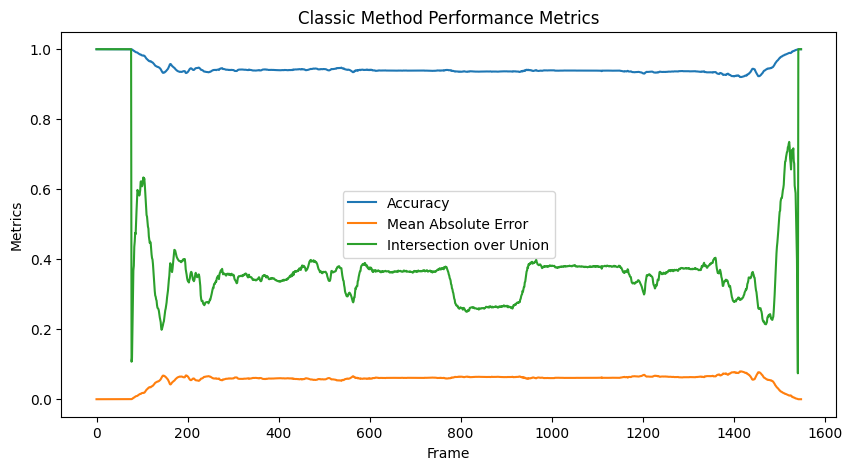

In [49]:
print(f'Average Accuracy: {np.mean(accuracies).round(2)*100}%')
print(f'Average Mean Absolute Error: {np.mean(MAEs).round(2)*100}%')
print(f'Average Intersection over Union: {np.mean(IOUs).round(2)*100}%')

plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.plot(MAEs, label='Mean Absolute Error')
plt.plot(IOUs, label='Intersection over Union')
plt.xlabel('Frame')
plt.ylabel('Metrics')
plt.legend()
plt.title('Classic Method Performance Metrics')
plt.show()